# Example 10: Cell Death Index

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = Client()
client

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35717 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35717/status,
Dashboard: http://127.0.0.1:35717/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42923,Workers: 8
Dashboard: http://127.0.0.1:35717/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:42055,Total threads: 4
Dashboard: http://127.0.0.1:44117/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:37217,


## Data Loading

In [3]:
CANCER_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Cancer/track_cancer_merge_int_contact_ddf.csv"

In [4]:
cancer_ddf = dd.read_csv(CANCER_DATA_PATH)
cancer_ddf

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Calculate CDI for the Cancer Cell

## Intensity Normalization

In [5]:
cancer_ddf, cancer_gfp_lp, cancer_gfp_up = intensity_norm_percentile(cancer_ddf,channel="gfp_mean", percentile=1)
cancer_ddf, cancer_pi_lp, cancer_pi_up = intensity_norm_percentile(cancer_ddf,channel="pi_mean", percentile=1)

## CDI Calculation

In [6]:
cancer_ddf = calculate_cdi(cancer_ddf, viability_col="gfp_mean_norm", death_col="pi_mean_norm")
cancer_ddf

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,CDI
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
cancer_ddf = compute_savgol_filter(cancer_ddf, track_id_col='track_id', frame_col='frame', value_col='CDI', window_length=500, polyorder=3)
cancer_ddf

/tmp/ipykernel_2222445/1828359640.py:61: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interpolated = ddf_sorted.groupby(track_id_col).apply(interpolate).reset_index(drop=True)
/tmp/ipykernel_2222445/1828359640.py:87: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interpolated = df_interpolated.groupby(track_id_col).apply(apply_savgol).reset_index(drop=True)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,CDI,CDI_smoothed,CDI_grad
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
cancer_df = cancer_ddf.compute()
cancer_df

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
 

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,CDI,CDI_smoothed,CDI_grad
0,29340237,87.361702,694.755319,690,82,11,11,694.755319,87.361702,690.0,...,163.060547,7.213069,0.315270,True,[281371],0.000161,0.148458,0.998918,0.994358,-0.000036
1,5548911,671.840426,932.468085,926,668,14,9,932.468085,671.840426,926.0,...,744.093750,447.450556,8.217729,True,[94218 94712],0.187284,0.005254,0.027289,0.028166,-0.000197
2,7168455,675.806723,740.844538,734,667,15,20,740.844538,675.806723,734.0,...,804.595703,894.687332,2.726144,True,[12290],0.283560,0.002921,0.010195,0.010340,0.000001
3,6855397,186.352564,55.647436,49,180,14,14,55.647436,186.352564,49.0,...,383.445312,152.651667,10.529616,False,[],0.052841,0.003498,0.062082,0.061361,-0.000271
4,9746558,65.142857,456.946429,453,61,9,10,456.946429,65.142857,453.0,...,703.660156,408.842311,2.912138,True,[173870 174439 174480 175320],0.171525,0.079923,0.317850,0.300361,0.000504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146856,17398824,476.839506,624.049383,617,471,15,15,624.049383,476.839506,617.0,...,465.294922,219.227412,16.504948,False,[],0.102266,0.014371,0.123212,0.111438,0.000051
146857,18243406,209.272085,470.144876,460,201,23,17,470.144876,209.272085,460.0,...,1308.796875,1298.142007,9.456160,True,[70962 71314],0.445896,0.015531,0.033659,0.038589,0.000235
146858,25711773,927.511628,456.511628,453,923,7,11,456.511628,927.511628,453.0,...,265.275391,58.534587,0.833110,True,[301502 304646],0.033188,0.589306,0.946686,0.933677,-0.004102
146859,26768501,208.754717,953.462264,948,203,12,13,953.462264,208.754717,948.0,...,269.287109,117.213831,8.129876,True,[237013],0.041542,0.065881,0.613288,0.636736,0.001371


## Plot CDI vs Time

### Single Cell

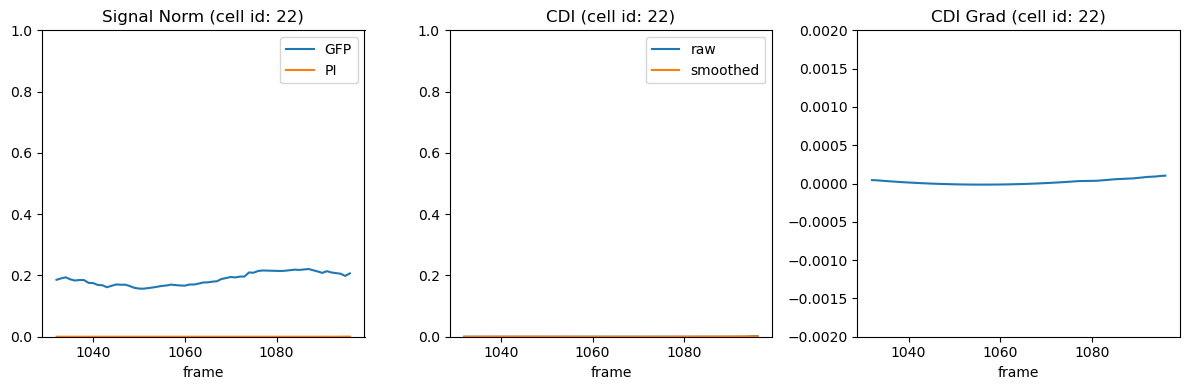

In [10]:
track_id = 22

res = cancer_df[cancer_df["track_id"]==track_id]
res = res.sort_values(by="frame")

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].plot(res["frame"], res["gfp_mean_norm"],label="GFP")
axs[0].plot(res["frame"], res["pi_mean_norm"], label="PI")
axs[0].set_title("Signal Norm (cell id: {})".format(track_id))
axs[0].set_ylim([0,1])
axs[0].set_xlabel("frame")
axs[0].legend()

axs[1].plot(res["frame"], res["CDI"],label="raw")
axs[1].plot(res["frame"], res["CDI_smoothed"], label="smoothed")
axs[1].set_title("CDI (cell id: {})".format(track_id))
axs[1].set_ylim([0,1])
axs[1].set_xlabel("frame")
axs[1].legend()

axs[2].plot(res["frame"], res["CDI_grad"],label="raw")
axs[2].set_title("CDI Grad (cell id: {})".format(track_id))
axs[2].set_xlabel("frame")
axs[2].set_ylim([-2e-3,2e-3])

fig.tight_layout()

### Ensemble

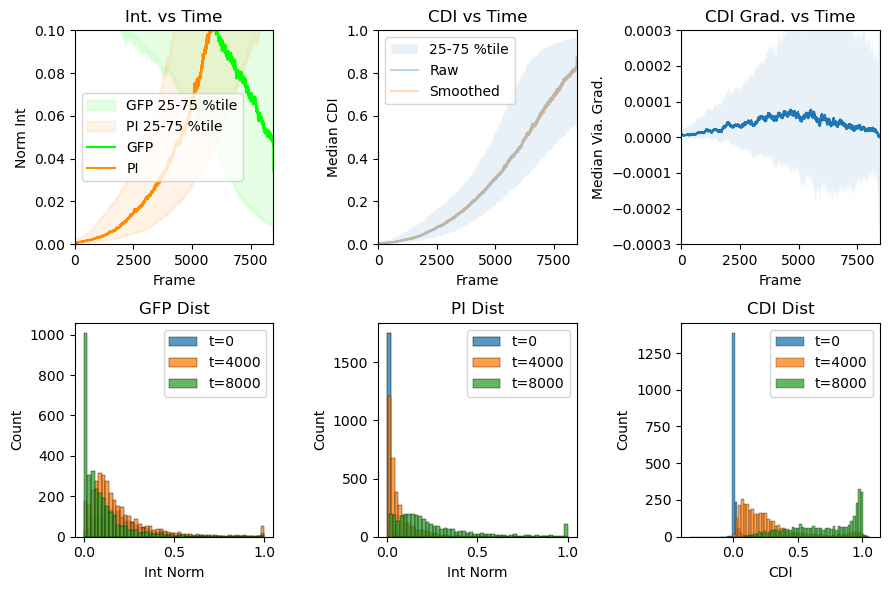

In [12]:
fig, axs = plt.subplots(2,3,figsize=(9,6))

def calc_percentiles(group):
    return pd.Series({
        '25th_percentile': group.quantile(0.25),
        '75th_percentile': group.quantile(0.75),
    })

######## Intensity ########
# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['gfp_mean_norm'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index

# Filling between 25th and 75th percentiles
axs[0,0].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, color='lime', label='GFP 25-75 %tile')

# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['pi_mean_norm'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index
axs[0,0].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, color='darkorange', label='PI 25-75 %tile')

axs[0,0].plot(cancer_df.groupby('frame')['gfp_mean_norm'].median(), label="GFP", c="lime")
axs[0,0].plot(cancer_df.groupby('frame')['pi_mean_norm'].median(), label="PI", c="darkorange")
axs[0,0].set_xlim(0,cancer_df["frame"].max() )
axs[0,0].set_ylim(0,0.1)
axs[0,0].set_ylabel("Norm Int")
axs[0,0].set_xlabel("Frame")
axs[0,0].set_title("Int. vs Time")
axs[0,0].legend()

######## CDI ########
# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['CDI_smoothed'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index

# Filling between 25th and 75th percentiles
axs[0,1].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, label='25-75 %tile')
axs[0,1].plot(cancer_df.groupby('frame')['CDI'].median(),label="Raw", alpha=0.3)
axs[0,1].plot(cancer_df.groupby('frame')['CDI_smoothed'].median(),label="Smoothed", alpha=0.3)
axs[0,1].set_ylabel("Median CDI")
axs[0,1].set_xlabel("Frame")
axs[0,1].set_title("CDI vs Time")
axs[0,1].set_xlim(0,cancer_df["frame"].max())
axs[0,1].set_ylim(0,1)
axs[0,1].legend()

####### CDI gradient ########
# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['CDI_grad'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index

# Filling between 25th and 75th percentiles
axs[0,2].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, label='25-75 %tile')
axs[0,2].plot(cancer_df.groupby('frame')['CDI_grad'].median())
axs[0,2].set_ylabel("Median Via. Grad.")
axs[0,2].set_xlabel("Frame")
axs[0,2].set_title("CDI Grad. vs Time")
axs[0,2].set_xlim(0,cancer_df["frame"].max() )
axs[0,2].set_ylim(-3e-4,3e-4)

####### histograms ########
axs[1,0].set_title("GFP Dist")
sns.histplot(cancer_df[cancer_df["frame"]==0]['gfp_mean_norm'], binwidth=0.02, label="t=0", ax=axs[1,0])
sns.histplot(cancer_df[cancer_df["frame"]==4000]['gfp_mean_norm'], binwidth=0.02, label="t=4000", ax=axs[1,0])
sns.histplot(cancer_df[cancer_df["frame"]==8000]['gfp_mean_norm'], binwidth=0.02, label="t=8000", ax=axs[1,0])
axs[1,0].legend()
axs[1,0].set_xlabel("Int Norm")

axs[1,1].set_title("PI Dist")
sns.histplot(cancer_df[cancer_df["frame"]==0]['pi_mean_norm'], binwidth=0.02, label="t=0", ax=axs[1,1])
sns.histplot(cancer_df[cancer_df["frame"]==4000]['pi_mean_norm'], binwidth=0.02, label="t=4000", ax=axs[1,1])
sns.histplot(cancer_df[cancer_df["frame"]==8000]['pi_mean_norm'], binwidth=0.02, label="t=8000", ax=axs[1,1])
axs[1,1].legend()
axs[1,1].set_xlabel("Int Norm")

axs[1,2].set_title("CDI Dist")
sns.histplot(cancer_df[cancer_df["frame"]==0]['CDI_smoothed'], binwidth=0.02, label="t=0", ax=axs[1,2])
sns.histplot(cancer_df[cancer_df["frame"]==4000]['CDI_smoothed'], binwidth=0.02, label="t=4000", ax=axs[1,2])
sns.histplot(cancer_df[cancer_df["frame"]==8000]['CDI_smoothed'], binwidth=0.02, label="t=8000", ax=axs[1,2])
axs[1,2].legend()
axs[1,2].set_xlabel("CDI")

plt.tight_layout()